In [14]:
import napari 

from dataset import (
    BlastoDataset,
    show_random_dataset_image,
    show_random_dataset_napari
)

In [15]:
dataset = BlastoDataset("training")

the mean intensity is 117.6194177886187 the std is 48.857714650562194


In [4]:
print(dataset)
print(dataset.__getitem__(4))

(tensor([[[-2.3998, -2.3986, -2.3995,  ..., -2.3989, -2.3994, -2.3997],
         [-2.3994, -2.3987, -2.3993,  ..., -2.3999, -2.3998, -2.3994],
         [-2.3990, -2.3993, -2.3994,  ..., -2.3992, -2.3995, -2.3992],
         ...,
         [-2.3991, -2.3990, -2.3995,  ..., -2.3996, -2.3990, -2.3995],
         [-2.3995, -2.3998, -2.3994,  ..., -2.3988, -2.3993, -2.3996],
         [-2.3992, -2.3994, -2.3994,  ..., -2.3993, -2.3995, -2.3996]]]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int16))


Image size is {torch.Size([256, 256])}


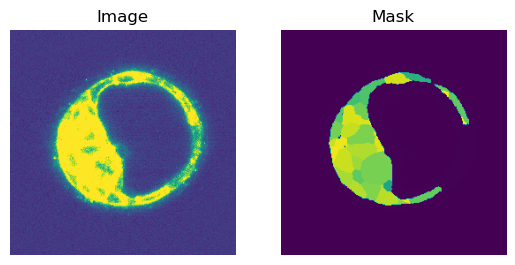

In [10]:
show_random_dataset_image(dataset)

In [11]:
img, mask = dataset[8]

In [12]:
dataset.__len__()

944

In [13]:
viewer  = napari.Viewer()

In [8]:
show_random_dataset_napari(dataset, viewer)